## 0. Data download

## 1. Folder init ()

In [55]:
import re
import csv
import os
import pandas as pd

batch_size = [20, 40, 80, 100, 200, 250, 400, 500]
folder_names = []
for bs in batch_size:
    folder_names.append("./batchsize_" + str(bs))

for folder_name in folder_names:
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        print(f"Folder '{folder_name}' created successfully.")
    else:
        print(f"Folder '{folder_name}' already exists.")

Folder './batchsize_20' created successfully.
Folder './batchsize_40' created successfully.
Folder './batchsize_80' created successfully.
Folder './batchsize_100' created successfully.
Folder './batchsize_200' created successfully.
Folder './batchsize_250' created successfully.
Folder './batchsize_400' created successfully.
Folder './batchsize_500' created successfully.


In [56]:
nn = [20000, 40000, 60000, 80000, 100000] # for synthetic data size
batch_size = [20, 40, 80, 100, 200, 250, 400, 500, 'exact']

exa_path = './synthetic_ds'
os.makedirs(exa_path, exist_ok=True)

for n in nn:
    dir_name = 's' + str(n)
    os.makedirs(dir_name, exist_ok=True)

## 2. log data preprocessing (ExaGeostat)

In [53]:
n_zvecs = 5  # total number of zvecs

### 2.2 log file summary

In [77]:
import numpy as np
# Open the input file and create a CSV output file
exact_time = []
for n in nn:
    dir_name = 's' + str(n)
    _e_tm = []
    for i in range(n_zvecs):
        # used for saving the results
        res_save = os.path.join(dir_name, 'bs_res_exact.csv')
        res_log = os.path.join(exa_path, 'log_' + str(n) + '_univariate_matern_stationary_' + str(i+1))
        
        with open(res_log, 'r') as f:
            lines = f.readlines()
            last_one_lines = lines[-2:-1]
            time = float(last_one_lines[0].split('=')[1].strip().split(' ')[0])
            _e_tm.append(time)
    exact_time.append(np.mean(time))

[4.6, 28.44, 91.43, 221.15, 405.98]


## 3. bash file init for vecchia

### 3.1 bash file created

There are some args to be noticed, such as tolerance, batchCount, etc!

In [54]:
batch_size_vec = batch_size[:-1]
batch_count = []
for n in nn:
    _bsc = []
    for bs in batch_size_vec:
        _bsc.append(int(n/bs))    
    batch_count.append(_bsc)

with open("run_script.sh", "w") as f:
    for i, n in enumerate(nn):
        for j, bs in enumerate(batch_size_vec):
            for k in range(n_zvecs):
                # construct the command line string
                cmd = f"./bin/test_dvecchia_batch -N {batch_size_vec[j]}:1 -s --batchCount {batch_count[i][j]} --vecchia --maxiter 1 --kernel 1 --num_loc {nn[i]} --zvecs {k+1} --tol 1e-5\n"
                f.write(cmd)

Next, you need to go run `bash ./data/run_script.sh` in the `~/testing`

### 3.2 Summary log summerized

In [69]:
import pandas as pd
import numpy as np
import glob

def read_files_and_concatenate(file_pattern, column_names, output_file):
    """
    Read multiple CSV files with the same format and concatenate them into a single DataFrame.
    
    Parameters:
    file_pattern (str): The file pattern to match, e.g. 'data_*.csv'
    column_names (list of str): The column names for the output DataFrame
    output_file (str): The filename to save the output DataFrame to
    
    Returns:
    None
    """
    # Create an empty DataFrame to hold the data
    df = pd.DataFrame(columns=column_names)

    # Iterate over all matching files
    for filename in glob.glob(file_pattern):
        # Load the current file into a DataFrame
        temp_df = pd.read_csv(filename)
        temp_df.columns = column_names
        # Append the data from the current file to the main DataFrame
        df = pd.concat([df, temp_df])
    # # Save the main DataFrame to a new file
    # df.to_csv(output_file, index=False)
    return np.mean(df['Time'])

In [88]:
# Create an empty DataFrame to hold the data
n_batch_time = []
for n in nn:
    col_name = ['Iterations', 'Time', 'variance', 'range', 'smoothness', 'log-likelihood']
    file_pattern = [f'batchsize_{bs}/sum_{n}_{bs}_*.csv' for bs in batch_size_vec]
    # output_file = [os.path.join(folder_name_sum, f'output_{bs}.csv') for bs in batch_size]
    _n_bs =[]
    for k in range(len(batch_size_vec)):
        _n_bs.append(read_files_and_concatenate(file_pattern[k], col_name, None))
    n_batch_time.append(_n_bs)
# print(np.asanyarray(n_batch_time).shape)
n_batch_time = np.asarray(n_batch_time)
exact_time = np.asarray(exact_time).reshape(-1, 1)
Total_time = np.concatenate((n_batch_time, exact_time), axis=1)

## 4. Result visulization

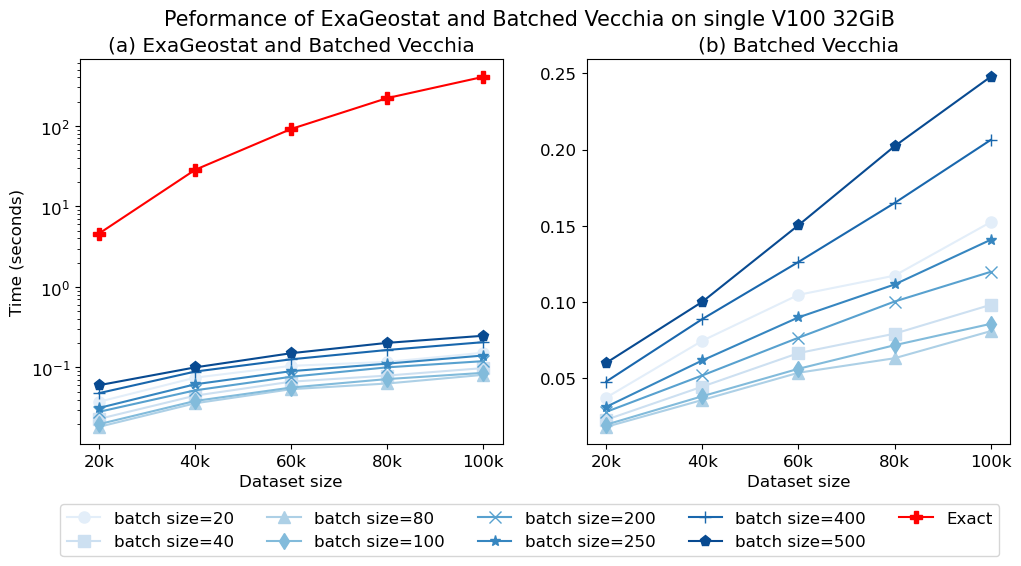

In [163]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the default font size
mpl.rcParams['font.size'] = 12

xx = ["20k", "40k", "60k", "80k", "100k"]
label = [f'batch size={bs}' for bs in batch_size_vec]
label.append('Exact')
markersize = 8

# Define custom colors and markers for the first 8 lines
colors = plt.cm.Blues(np.linspace(0.1, 0.9, 8))
markers = ['o', 's', '^', 'd', 'x', '*', '+', 'p', 'P']

data = Total_time

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the data for the first subplot (9 lines)
for i in range(9):
    if i == 8:
        axs[0].plot(data[:, i], label=label[i], color='red', marker=markers[i], markersize=markersize)
    else:
        axs[0].plot(data[:, i], label=label[i], color=colors[i], marker=markers[i], markersize=markersize)

# Set x-axis tick labels and add legend for the first subplot
axs[0].set_xticks(range(len(xx)))
axs[0].set_xticklabels(xx)
axs[0].set_yscale('log')
axs[0].set_ylabel('Time (seconds)')
axs[0].set_xlabel('Dataset size')

# Plot the data for the second subplot (8 lines)
for i in range(8):
    axs[1].plot(data[:, i], label=label[i], color=colors[i], marker=markers[i], markersize=markersize)

# Set x-axis tick labels and add legend for the second subplot
axs[1].set_xticks(range(len(xx)))
axs[1].set_xticklabels(xx)
axs[1].set_xlabel('Dataset size')

# Create a single legend for both subplots and place it at the bottom of the figure
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', 
           ncol=5, bbox_to_anchor=(0.5, -0.13))

# Set titles for the subplots
axs[0].set_title('(a) ExaGeostat and Batched Vecchia')
axs[1].set_title('(b) Batched Vecchia')
# plt.subplots_adjust(top=0.85, bottom=0.15, wspace=0.3, hspace=0.2)
fig.suptitle('Peformance of ExaGeostat and Batched Vecchia on single V100 32GiB', fontsize=15, y=0.98)

# Add space between the subplots
plt.subplots_adjust(wspace=0.2)
plt.savefig('../fig/perf_v100_scale1.pdf', format='pdf', bbox_inches='tight')
plt.show()